# Data Loading

In [1]:
from datasets import load_dataset

# Load dataset (includes train, test, val)
dataset = load_dataset("hf-vision/chest-xray-pneumonia")

In [2]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5216
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 16
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})


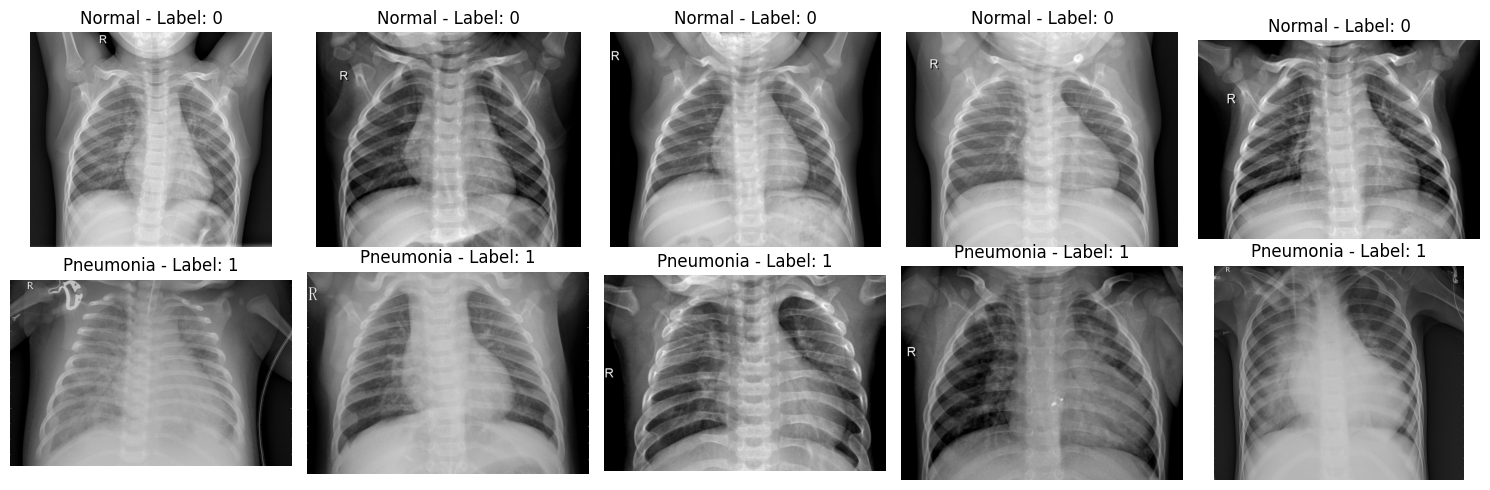

In [3]:
import matplotlib.pyplot as plt

def plot_samples(dataset_split, num_samples=5):
    plt.figure(figsize=(15, 5))
    indices = {0: [], 1: []}
    
    # Get some indices for both classes
    for idx, sample in enumerate(dataset_split):
        if len(indices[sample['label']]) < num_samples:
            indices[sample['label']].append(idx)

    # Plot NORMAL
    for i, idx in enumerate(indices[0]):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(dataset_split[idx]['image'], cmap='gray')
        plt.title(f"Normal - Label: {dataset_split[idx]['label']}")
        plt.axis('off')

    # Plot PNEUMONIA
    for i, idx in enumerate(indices[1]):
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(dataset_split[idx]['image'], cmap='gray')
        plt.title(f"Pneumonia - Label: {dataset_split[idx]['label']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show samples from training set
plot_samples(dataset['train'], num_samples=5)

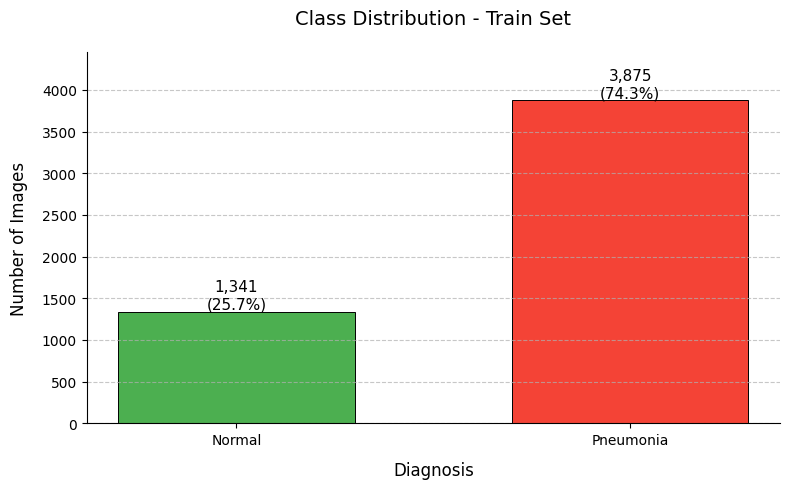

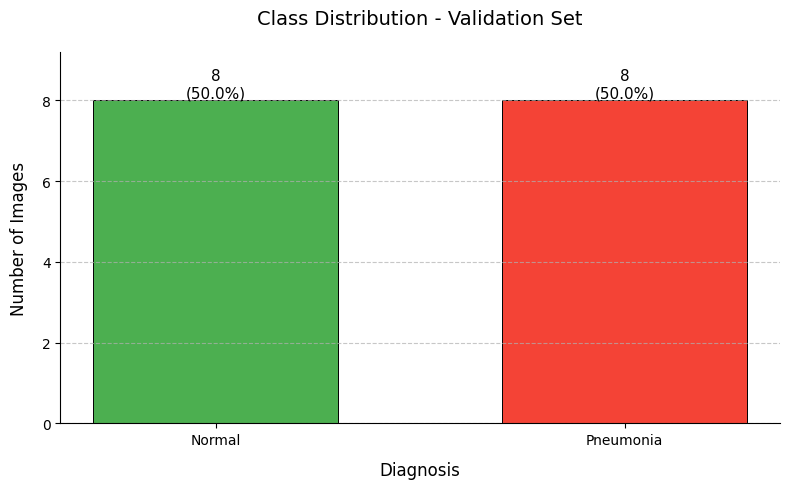

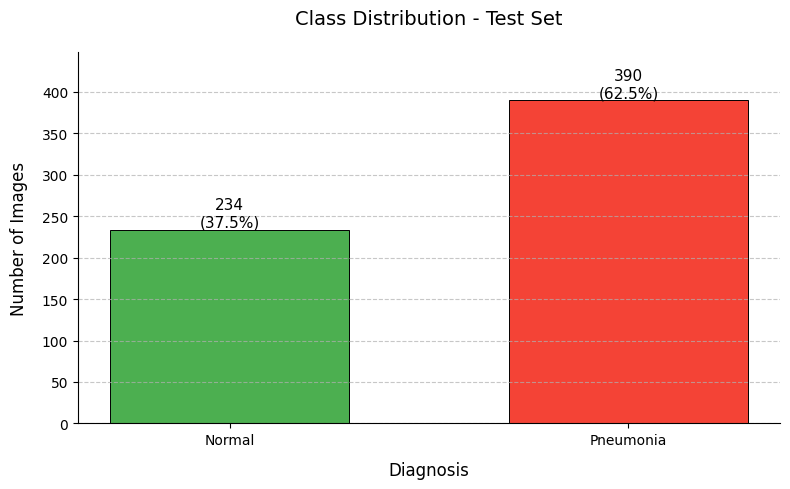

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(dataset_split, split_name):
    # Get counts for each class
    labels = np.array(dataset_split['label'])  # More efficient way to get labels
    class_counts = np.bincount(labels)
    classes = ['Normal', 'Pneumonia']
    
    # Create figure with better proportions
    plt.figure(figsize=(8, 5))
    
    # Create bars with improved styling
    bars = plt.bar(classes, class_counts, 
                  color=['#4CAF50', '#F44336'],  # Better colors
                  width=0.6,  # Adjust width
                  edgecolor='black', linewidth=0.7)  # Add borders
    
    # Add title and labels with improved styling
    plt.title(f'Class Distribution - {split_name} Set', 
             fontsize=14, pad=20)
    plt.ylabel('Number of Images', fontsize=12, labelpad=10)
    plt.xlabel('Diagnosis', fontsize=12, labelpad=10)
    
    # Remove top and right spines
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}\n({height/len(labels):.1%})',  # Show count and percentage
                ha='center', va='bottom',
                fontsize=11)
    
    # Adjust y-axis to give room for labels
    plt.ylim(0, max(class_counts) * 1.15)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot distributions for all splits
for split_name, split_data in dataset.items():
    plot_class_distribution(split_data, split_name.capitalize())

## Check imaage channels

In [5]:
import numpy as np

# Function to check image channels
def check_image_channels(dataset_split):
    for idx, sample in enumerate(dataset_split):
        image = sample['image']
        print(f"Sample {idx}: Image Shape - {image.size}, Mode - {image.mode}")
        if idx >= 5:  # Check first 5 samples
            break

# Check the first few samples from the training set
check_image_channels(dataset['train'])

Sample 0: Image Shape - (2090, 1858), Mode - L
Sample 1: Image Shape - (1422, 1152), Mode - L
Sample 2: Image Shape - (1810, 1434), Mode - L
Sample 3: Image Shape - (1618, 1279), Mode - L
Sample 4: Image Shape - (1600, 1125), Mode - L
Sample 5: Image Shape - (1974, 1306), Mode - L


## Histogram

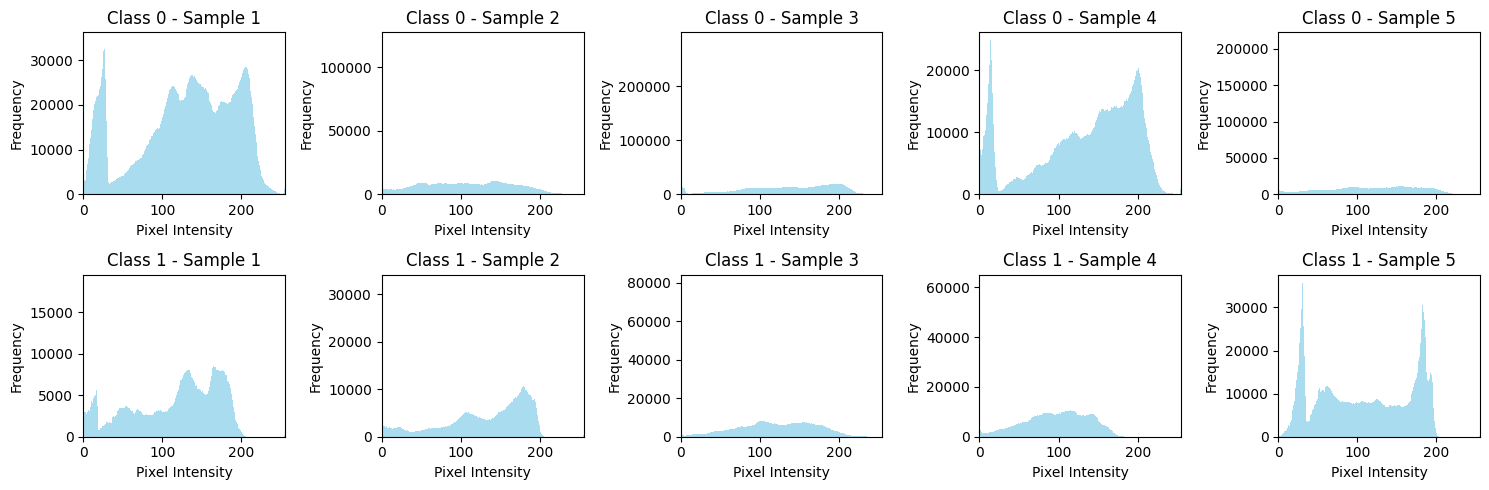

In [6]:
import matplotlib.pyplot as plt

def plot_pixel_intensity_histograms(dataset_split, num_samples=5):
    plt.figure(figsize=(15, 5))
    
    # Plot histograms for both classes
    for label in [0, 1]:  # Normal (0) and Pneumonia (1)
        class_images = []
        
        # Collect pixel values for the current class
        for idx, sample in enumerate(dataset_split):
            if sample['label'] == label and len(class_images) < num_samples:
                image = sample['image']
                class_images.append(np.array(image).flatten())  # Flatten the image
        
        # Plot histograms
        for i, pixels in enumerate(class_images):
            plt.subplot(2, num_samples, label * num_samples + i + 1)
            plt.hist(pixels, bins=256, color='skyblue', alpha=0.7)
            plt.title(f"Class {label} - Sample {i+1}")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")
            plt.xlim(0, 255)  # Pixel values range from 0 to 255
        
    plt.tight_layout()
    plt.show()

# Plot histograms for the training set
plot_pixel_intensity_histograms(dataset['train'], num_samples=5)

##  Visualize Single Image Histogram

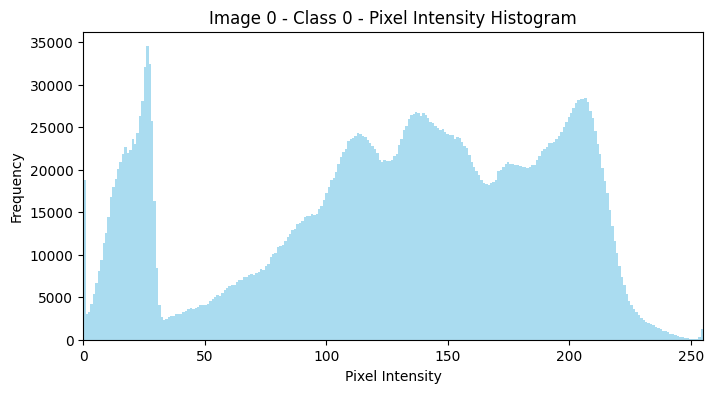

In [7]:
def plot_single_image_histogram(sample_idx, dataset_split):
    sample = dataset_split[sample_idx]
    image = sample['image']
    pixels = np.array(image).flatten()
    
    plt.figure(figsize=(8, 4))
    plt.hist(pixels, bins=256, color='skyblue', alpha=0.7)
    plt.title(f"Image {sample_idx} - Class {sample['label']} - Pixel Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim(0, 255)
    plt.show()

# Plot histogram for a single image (e.g., index 0)
plot_single_image_histogram(0, dataset['train'])

# Applying transforms to data

In [17]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

# Updated transform to enforce RGB, resize, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

# Only applied during training
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),              # Standard resize
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]), # Normalize intensity range

    # 🔁 Random augmentations below:
    transforms.RandomRotation(10),               # Random rotation up to 10 degrees
    transforms.RandomAffine(
        degrees=0,                                # No rotation
        translate=(0.1, 0.1),                     # Random translation
        scale=(0.9, 1.1)                          # Random zoom
    ),
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2             # Adjust brightness/contrast
    ),
    transforms.RandomHorizontalFlip(p=0.5),      # Flip horizontally randomly
])

# Validation/test transform (no augmentation)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [18]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define Custom Dataset
class ChestXRayDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'].convert("L")  # Grayscale

        if self.transform:
            image = self.transform(image)

        return image, item['label']


# Create dataset and dataloaders
def get_dataloaders(batch_size=32):
    # Load dataset
    dataset = load_dataset("hf-vision/chest-xray-pneumonia")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Wrap splits
    train_dataset = ChestXRayDataset(dataset['train'], transform=transform_train)
    val_dataset = ChestXRayDataset(dataset['validation'], transform=transform_val)
    test_dataset = ChestXRayDataset(dataset['test'], transform=transform_val)

    # Custom collate function
    def custom_collate(batch):
        batch = [item for item in batch if item[0].ndim == 3]
        images = torch.stack([item[0] for item in batch])
        labels = torch.tensor([item[1] for item in batch])
        return images, labels

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    print("✅ DataLoaders created successfully!")
    return train_loader, val_loader, test_loader

In [19]:
if __name__=="_main_":
    train_loader, val_loader, test_loader = get_dataloaders()